# Coding Assignment 1: Image Classification
- In this assignment you have to train image classification model with __your own data__


In [2]:
import torch
torch.cuda.set_device('cuda:1')

## 0. Install Library and Import

In [3]:
!pip install -Uqq fastbook
!pip install -q fastai==2.5.2
!pip install -q jmd_imagescraper

from fastai.vision.all import *
from fastai.vision.widgets import *
from fastbook import *
from jmd_imagescraper.core import duckduckgo_search
import random
import shutil
import os

/opt/conda/lib/python3.8/site-packages/fastbook/__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


## 1. Select the storage type
- Since Colab storage is volatile, your image dataset or model would disappear after the session ends.
- There are two options to save the data permanently:
  1. Save your data in your local computer by downloading it from Colab. select `SAVE_TYP='local'`
  2. Save your data in your Google Drive storage. select `SAVE_TYP='google_drive'`
- If you are running on your local computer, use `SAVE_TYP='local'`


In [4]:
SAVE_TYP = 'local'
# SAVE_TYP = 'google_drive'
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

## Problem 1: Collect Data (20 pts)
- You have to select 4 image categories of your own choice
- The selected categories will be used as an image class for the classification model
- Evaluation:
    - If you select 4 

In [5]:
def configure_image_categories():
  '''
  input: None
  output: List of strings that contains 4 classes

  example: image_keywords = ['football', 'basketball', 'baseball', 'volleyball']
  '''
  # TODO: Complete the function
  image_keywords = ['football_match', 'basketball_match', 'baseball_match', 'volleyball_match']
  return image_keywords



## Image Crawling
- Following code will automatically crawl the images with the keyword you have choosen
- After running it, it will automatically split train and valid to ratio of 8:2
  - Training data will be located `images/train`
  - Validation data will be locatd `images/valid`


In [6]:
def get_image_using_duckduckgo(img_dir:Path, image_types: list, num_img:int):
  for typ in image_types:
    duckduckgo_search(img_dir, typ, typ, max_results=NUM_IMG)
    typ_dir = img_dir / typ
    img_files = get_image_files(typ_dir)
    failed = verify_images(img_files)
    failed.map(Path.unlink)

def split_train_and_valid(img_dir, image_types, random_seed=0):
  random.seed(random_seed)
  num_img = len((img_dir/image_types[0]).ls())
  valid_indices = random.sample(range(num_img), num_img//5)
  for typ in image_types:
    typ_dir = img_dir / typ
    if not typ_dir.exists():
      continue
    train_dir = img_dir / 'train' / typ
    valid_dir = img_dir / 'valid' / typ
    train_dir.mkdir(parents=True, exist_ok=True)
    valid_dir.mkdir(parents=True, exist_ok=True)
    img_files = get_image_files(typ_dir)
    for fn in img_files[valid_indices]:
      shutil.move(fn, valid_dir/fn.name)
    img_files = get_image_files(typ_dir)
    for fn in img_files:
      shutil.move(fn, train_dir/fn.name)
    assert len(get_image_files(typ_dir)) == 0, f"There are still remaining files in {typ_dir}"
    os.rmdir(typ_dir)

In [52]:
NUM_IMG = 100

image_types = configure_image_categories()
assert len(image_types)==4, "The length of image types has to be 4"
assert all( isinstance(typ, str) for typ in image_types), "Every element of image_types has to be string"

img_dir = Path('images')
plot_dir = Path('plots')
plot_dir.mkdir(exist_ok=True)


In [54]:
if not img_dir.exists(): # If there is no image directory
  if Path("image_data.zip").exists(): # If image_data.zip file exists
    os.system("unzip -q image_data.zip") # Unzip the zip file
  else: # If there is no image directory and also no image_data.zip
    get_image_using_duckduckgo(img_dir, image_types, NUM_IMG) # Download image files
    split_train_and_valid(img_dir, image_types) # Split train and valid into different directories
    os.system(f"zip -rq image_data.zip {img_dir}") # Make zip file that contains images directory
    if IN_COLAB: # If you are running this notebook on Colab 
      if SAVE_TYP == 'local': # if you selected to save it in local
        from google.colab import files
        files.download('image_data.zip')   # download the zip file to your local computer 
      else:
        from google.colab import drive # if you selected to save it in local
        drive.mount('/content/drive') 
        shutil.copy("image_data.zip", '/content/drive/My\ Drive/')  # copy the zipfile to your google drive

- If you want 

## Problem 2: Plot your Dataset
- It is always important to check your dataset in detail
- Run the script below and see the result
  - The figure will automatically saved as png with current time

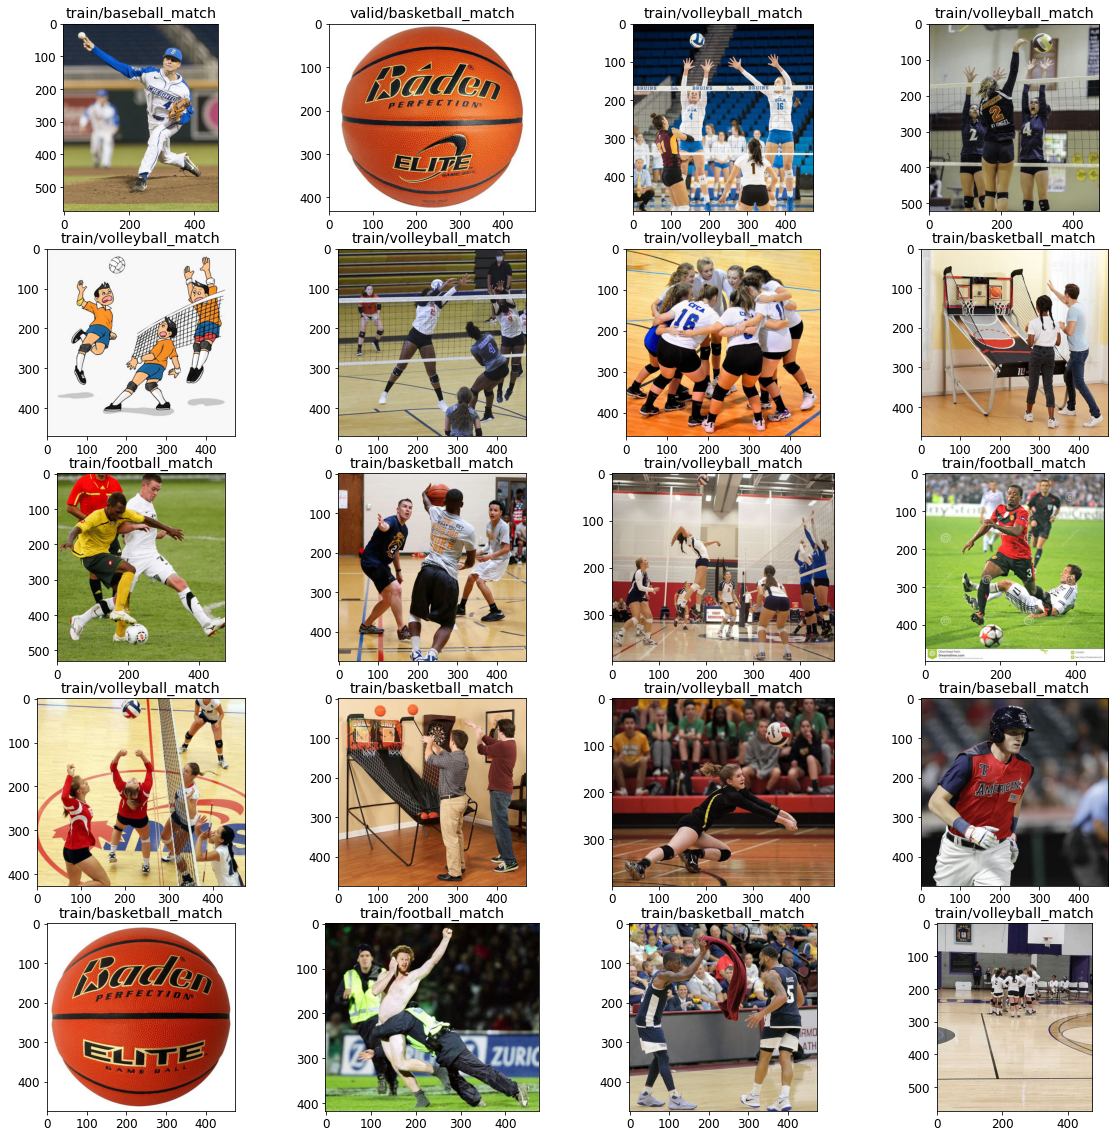

In [58]:
def plot_random_sampled_images(img_dir, ncols=4, nrows=5,random_seed=0):
  list_of_image_files = list(img_dir.rglob("*.jpg"))
  random.seed(random_seed)
  random.shuffle(list_of_image_files)
  plt.figure(figsize=(ncols*5,nrows*4))
  for i in range(ncols*nrows):
    fname = list_of_image_files[i]
    image = Image.open(fname)
    plt.subplot(nrows,ncols, i+1)
    plt.imshow(image)
    plt.title('/'.join(str(fname.parent).split('/')[-2:]))
  plt.savefig(plot_dir/f"dataset_check_{'_'.join(time.ctime().split(' ')[1:4])}.png")

plot_random_sampled_images(img_dir)


## Problem 2: Report the first training result (20 pts)
- Use the default settings of fastai
    - without data augmentation

### DataBlock
Class that can feed data in a right format to fastai model.
* *blocks*: type of input/labels. 
  * *(ImageBlock, CategoryBlock)* means that input is image and label is categorical value
* *get_items*: a function to load item from storage. 
  * *get_image_files* is a fastai function that get lists of image files in a given directory
* *splitter*: a function to split train and validation
  * *GrandparentSplitter* splits dataset by its Grandparent directory (parent directory of parent directory) name.
* *get_y*: a function to get label 
  * *parent_label* means to use name of parent directory of item as the label
* *item_tfms*: item transformation. How to transform the loaded item before feeding it to a neural network model
  * *Resize* is to resize entire image into square of certain size. 

In [21]:
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = images.dataloaders(img_dir)

Check the Batch result

In [ ]:
dls.train.show_batch(max_n=40, ncols=5, unique=False)

In [1]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(20) 

NameError: name 'cnn_learner' is not defined

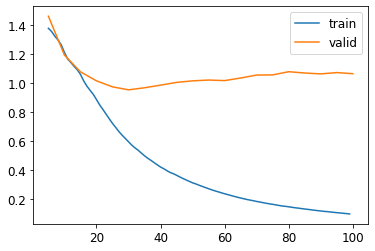

In [25]:
learn.recorder.plot_loss()
plt.savefig('loss')

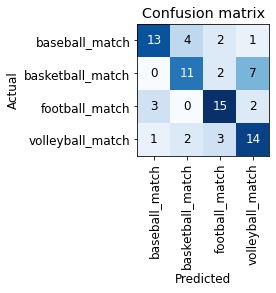

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

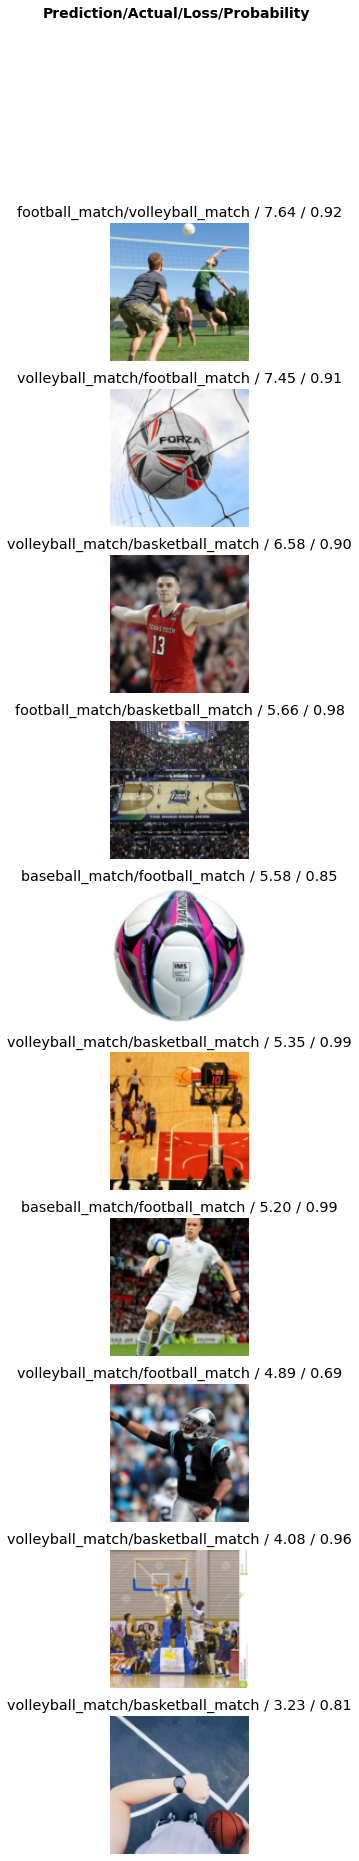

In [13]:
interp.plot_top_losses(10, ncols=1)

## Problem 3: Try other settings 
- Try Data Augmentation with `DataBlock`
- Try various learning rates

In [ ]:
dir(interp)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__stored_args__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'confusion_matrix',
 'decoded',
 'dl',
 'from_learner',
 'inputs',
 'losses',
 'most_confused',
 'plot_confusion_matrix',
 'plot_top_losses',
 'preds',
 'print_classification_report',
 'targs',
 'top_losses',
 'vocab']

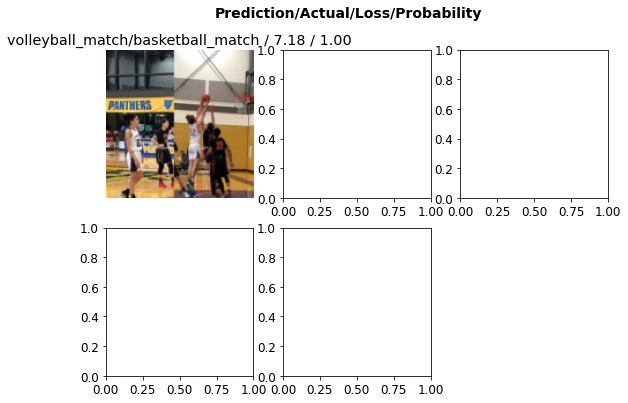

In [11]:
interp.plot_top_losses(5)

In [15]:
from jmd_imagescraper.imagecleaner import display_image_cleaner

display_image_cleaner('images/valid')

HTML(value='<h2>No images left to display in this folder.</h2>', layout=Layout(visibility='hidden'))

GridBox(children=(VBox(children=(Image(value=b'', layout="Layout(width='150px')"), Button(description='Delete'…